# Waterbody Time Series with Sentinel 2 <img align="right" src="../../Supplementary_data/dea_logo.jpg">

* **Compatibility:** Notebook currently compatible with both the NCI and DEA Sandbox environments. 
* **Products used:** [DEA Waterbodies](https://cmi.ga.gov.au/data-products/dea/456/waterboards), [s2a_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2a_ard_granule), [s2b_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2b_ard_granule)
* **Special requirements:** `dea_tools`, `ephem`, `wofs`

## Background
On average, the Australian Government invests around half a billion dollars a year in monitoring, protecting and enhancing Australia's land, coasts and oceans. DEA provides near real-time satellite information which can be used by government to better target these investments.

Water is among one the most precious natural resources and is essential for the survival of life on Earth. Within Australia, the scarcity of water is both an economic and social issue. Water is required not only for consumption but for industries and environmental ecosystems to function and flourish. 

With the demand for water increasing, there is a need to better understand our water availability to ensure we are managing our water resources effectively and efficiently.  

Digital Earth Australia (DEA)'s [Water Observations from Space (WOfS) dataset](https://www.sciencedirect.com/science/article/pii/S0034425715301929), provides a water classified image of Australia approximately every 16 days. These individual water observations have been combined into a [WOfS summary product](https://explorer.sandbox.dea.ga.gov.au/wofs_summary), which calculates the frequency of wet observations (compared against all clear observations of that pixel), over the full 30 year satellite archive. 

The WOfS summary product provides valuable insights into the persistence of water across the Australian landscape on a pixel by pixel basis. While knowing the wet history of a single pixel within a waterbody is useful, it is more useful to be able to map the whole waterbody as a single object. This is the purpose of DEA Waterbodies: aggregating water observations for each waterbody on an object level Australia-wide.

The water observations that contribute to DEA Waterbodies come solely from Landsat 5, 7, and 8. Sentinel 2 observations, if incorporated, would be able to increase the temporal resolution dramatically.

## Description

This notebook demonstrates the utility of using Sentinel 2 observations to measure water surface areas in addition to existing Landsat 5/7/8 observations. We will

1. Estimate a high-temporal resolution surface area time series for Lake Victoria based on its volume gauge,
2. Run WOfS on Sentinel 2 imagery for Lake Victoria over all available times,
3. Generate a combined surface area time series using Landsat WOfS and Sentinel 2.

## Getting started

To run this analysis, work through this notebook starting with the "Install packages" cell.

## Install packages

We have three dependencies when running on DEA Sandbox that are not already installed. Install them (this may require restarting the kernel):

In [1]:
%%bash
pip install -e /home/jovyan/dea-notebooks/Tools/
pip install ephem
pip install --index-url https://packages.dea.ga.gov.au/ wofs

Obtaining file:///home/jovyan/dea-notebooks/Tools
  Attempting uninstall: dea-tools
    Found existing installation: dea-tools 0.1.0
    Uninstalling dea-tools-0.1.0:
      Successfully uninstalled dea-tools-0.1.0
  Running setup.py develop for dea-tools
Looking in indexes: https://packages.dea.ga.gov.au/


You should consider upgrading via the '/env/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/env/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/env/bin/python3 -m pip install --upgrade pip' command.


### Load packages
Import Python packages that are used for the analysis.

In [2]:
import csv
from pathlib import Path
import warnings

import datacube
import geopandas as gpd
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import rasterio
import scipy.optimize as opt

from dea_tools.waterbodies import get_time_series, get_waterbody
from dea_tools.spatial import xr_rasterize
from dea_tools.datahandling import load_ard
from dea_tools.plotting import rgb

import wofs.wofls
import rioxarray

/env/lib/python3.6/site-packages/cligj/__init__.py:17: FutureWarning: cligj 1.0.0 will require Python >= 3.7
  warn("cligj 1.0.0 will require Python >= 3.7", FutureWarning)


## Estimate a high-temporal resolution surface area curve

Lake Victoria has its water volumes tracked. By using the waterbody time series we can estimate a surface area-volume relationship and hence get an approximate surface area curve at much higher temporal resolution than satellite observations provide.

Load the surface areas from DEA Waterbodies:

In [3]:
geohash = "r1uqwu1sz"  # Lake Victoria
ts_sa = get_time_series(geohash=geohash)

And the volumes, which we previously downloaded from [Water Data Online](http://www.bom.gov.au/waterdata/):

In [4]:
ts_vol = pd.read_csv("csv.w00209.20210105164601.A4261093.csv", skiprows=9).set_index(
    "#Timestamp"
)

Fix the indexes to be datetimes in the same timezone:

In [5]:
# Convert the volume index to a datetime (the surface area index already is a datetime)
ts_vol.index = pd.to_datetime(ts_vol.index)

# Normalise the indexes and put them both in UTC.
# UTC is used by DEA Waterbodies already.
ts_sa.index = ts_sa.index.normalize()
ts_vol.index = ts_vol.index.tz_convert("UTC").normalize()

Combine the dataframes and sort by the surface area:

In [6]:
joined = ts_sa.join(ts_vol, how="left")

There are some outliers in these data. Plot the surface area against the volume to see them:

In [7]:
# Filter out rows without volume measurements or with bad quality measurements:
ok = pd.notnull(joined.Value) & (joined["Quality Code"] == 10)

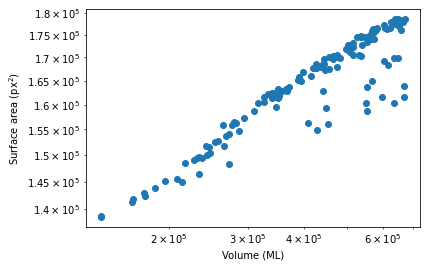

In [8]:
# Plot the surface area against the volume:
plt.scatter(joined.Value[ok], joined.px_wet[ok])
plt.ylabel("Surface area (px$^2$)")
plt.xlabel("Volume (ML)")
plt.yscale("log")
plt.xscale("log");

We will remove the outliers by fitting a polynomial, estimating the standard deviation of the data around this polynomial, and remove points above one standard deviation away from the line. Fitting the line won't work very well with least squares regression though because of the outliers, so instead we'll use L1 regression which is less sensitive to outliers (for some inutition about how this is the case, recall that the least-squares minimiser is the mean, but the L1 minimiser is the median).

In [9]:
# Fit the polynomial


def loss(params, x, y):
    m, b = params
    t = m * x + b
    return np.abs(t - y).mean()


pf = opt.fmin(
    loss, (1, 0), args=(np.log10(joined["Value"][ok]), np.log10(joined["px_wet"][ok]))
)

Optimization terminated successfully.
         Current function value: 0.006484
         Iterations: 85
         Function evaluations: 159


In [10]:
# Evaluate the polynomial on known volumes
pv = 10 ** np.polyval(pf, np.log10(joined["Value"]))

In [11]:
# Estimate the deviation
stdev = np.std(joined.px_wet[ok] - pv[ok])

Text(0.5, 0, 'Volume (ML)')

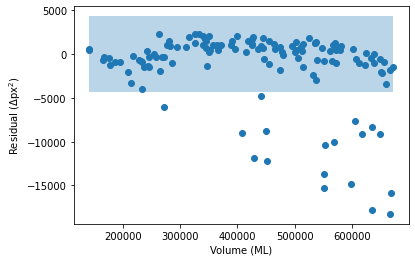

In [12]:
# Visualise the outlier removal
plt.scatter(joined.Value[ok], joined.px_wet[ok] - pv[ok])
plt.fill_between(
    [joined.Value[ok].min(), joined.Value[ok].max()],
    -stdev,
    stdev,
    alpha=0.3,
    facecolor="C0",
)
plt.ylabel("Residual ($\Delta$px$^2$)")
plt.xlabel("Volume (ML)")

In [13]:
# Get the outliers
is_outlier = abs(joined.px_wet - pv) > stdev

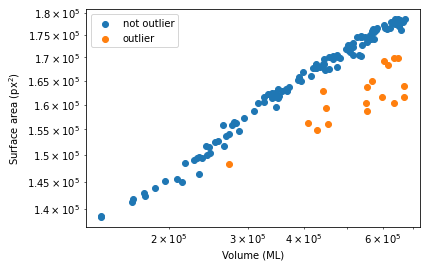

In [14]:
# Plot the surface area against the volume but highlight outliers this time:
plt.scatter(
    joined.Value[ok & ~is_outlier], joined.px_wet[ok & ~is_outlier], label="not outlier"
)
plt.scatter(
    joined.Value[ok & is_outlier], joined.px_wet[ok & is_outlier], label="outlier"
)
plt.ylabel("Surface area (px$^2$)")
plt.xlabel("Volume (ML)")
plt.yscale("log")
plt.xscale("log")
plt.legend();

With the outliers removed, we can now estimate the surface area-volume relationship. We'll fit a log-cubic.

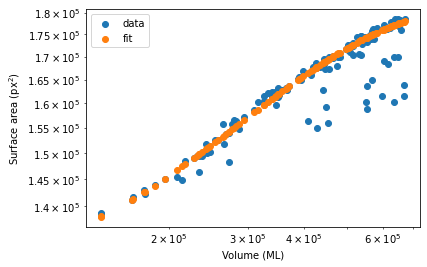

In [15]:
# Recalculate the polyfit
pf = np.polyfit(
    np.log10(joined["Value"][ok & ~is_outlier]),
    np.log10(joined["px_wet"][ok & ~is_outlier]),
    deg=3,
)
pv = 10 ** np.polyval(pf, np.log10(joined["Value"]))
# Then scatter plot:
plt.scatter(joined.Value[ok], joined.px_wet[ok], label="data")
plt.scatter(joined.Value[ok], pv[ok], label="fit")
plt.ylabel("Surface area (px$^2$)")
plt.xlabel("Volume (ML)")
plt.yscale("log")
plt.xscale("log")
plt.legend();

This lets us get a time series of surface areas.

In [16]:
ts_vol["px_wet_est"] = 10 ** np.polyval(pf, np.log10(ts_vol.Value))
ts_vol.loc[ts_vol["Quality Code"].values != 10, "px_wet_est"] = np.nan

In [17]:
est_err = np.std(joined["px_wet"][ok & ~is_outlier] - pv[ok & ~is_outlier])

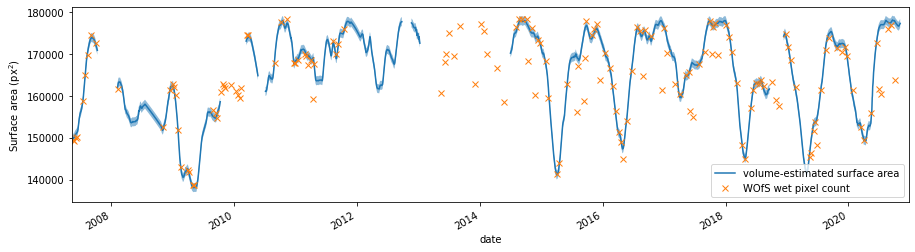

In [18]:
plt.figure(figsize=(15, 4))
plt.plot(ts_vol.index, ts_vol.px_wet_est, label="volume-estimated surface area")
plt.fill_between(
    ts_vol.index, ts_vol.px_wet_est - est_err, ts_vol.px_wet_est + est_err, alpha=0.5
)
ts_sa.px_wet.plot(label="WOfS wet pixel count", marker="x", linewidth=0)
plt.xlim(ts_vol.index[0], ts_vol.index[-1])
plt.ylabel("Surface area (px$^2$)")
plt.legend();

There are some inconsistencies. These seem to be related to WOfS rather than problems with the polynomial fit; examining a few of the very different timestamps shows places where WOfS has marked much of the lake as invalid.

## Load Sentinel 2 time stack

Set up the datacube and load a full time stack of Sentinel 2 data.

In [19]:
# Set up the datacube:
dc = datacube.Datacube(app="WaterbodyTimeSeriesS2")

In [20]:
# Load the waterbody shape:
shape = get_waterbody(geohash)

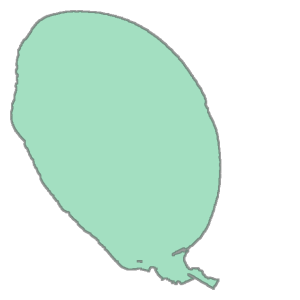

In [21]:
shape.geometry[0]

Query the datacube. We will downsample Sentinel 2 to match DEA Waterbodies/WOfS.

In [22]:
# Only get Sentinel 2 data for times that we have volumes for.
time_period = (ts_vol.index[0], ts_vol.index[-1])

In [23]:
ds = load_ard(
    dc,
    products=["s2a_ard_granule", "s2b_ard_granule"],
    resolution=(-25, 25),
    output_crs="EPSG:3577",
    min_gooddata=0.9,
    geopolygon=datacube.utils.geometry.Geometry(
        shape.geometry[0].buffer(100), crs="EPSG:3577"
    ),
    time=time_period,
)

Finding datasets
    s2a_ard_granule
    s2b_ard_granule
Counting good quality pixels for each time step
Filtering to 253 out of 566 time steps with at least 90.0% good quality pixels
Applying pixel quality/cloud mask
Loading 253 time steps


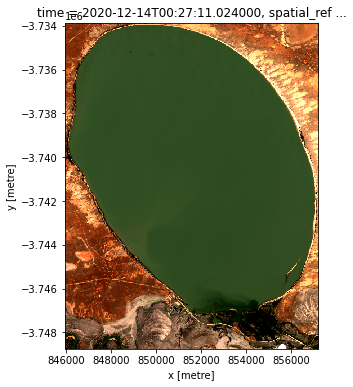

In [24]:
rgb(ds.isel(time=-1))

## Run WOfS

We will run WOfS on the Sentinel 2 images, ignoring any potential correction factors we might want to make to the Sentinel 2 bands. This is a fairly naive approach!

First we need a DEM. To run this on DEA Sandbox, we'll use a DEM downloaded from ELVIS and processed in QGIS.

In [25]:
# Open the DEM, which is in EPSG:3577
dem = xr.open_rasterio("lakevictoria.tif")

In [26]:
# Screen out no-data
dem = dem.where(dem != dem.nodatavals[0])

In [27]:
# Set zero pixels (water) to the minimum to avoid edge effects in WOfS terrain shadows
dem.isel(band=0).values[(dem == 0).values[0]] = dem.where(dem > 0).min()

In [28]:
# Convert into an xarray dataset for WOfS
dem = xr.Dataset({"elevation": dem.isel(band=0)})

In [29]:
# Set nodata attrs
ds.attrs["nodata"] = np.nan
for band in ds.variables:
    ds[band].attrs["nodata"] = np.nan

In [30]:
# and the CRS
dem.attrs["crs"] = "EPSG:3577"

Reproject the DEM:

In [31]:
transform, width, height = rasterio.warp.calculate_default_transform(
    "EPSG:3577", "EPSG:3577", dem.rio.width, dem.rio.height, *dem.rio.bounds()
)

In [32]:
dem_reproj = rasterio.warp.reproject(
    source=dem.elevation,
    src_transform=dem.rio.transform(),
    src_crs=dem.crs,
    destination=ds.rename({"nbar_blue": "elevation"}).elevation.isel(time=0).copy(),
    dst_transform=ds.rio.transform(),
    dst_crs=ds.crs,
    resampling=rasterio.warp.Resampling.bilinear,
)[0]

Then we can run WOfS on each image, producing Sentinel 2 WOfLS.

In [33]:
s2_wofls = []
for i in tqdm(range(len(ds.time))):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        s2_wofls_ = wofs.wofls.woffles_ard(
            ds.rename(
                {
                    "nbart_nir_1": "nbart_nir",
                    "nbart_swir_2": "nbart_swir_1",
                    "nbart_swir_3": "nbart_swir_2",
                }
            ).isel(time=i),
            xr.Dataset({"elevation": dem_reproj}, attrs={"crs": "EPSG:3577"}),
        )
        s2_wofls.append(s2_wofls_)

In [34]:
s2_wofs = xr.concat(s2_wofls, dim="time")

Apply cloud masking:

In [35]:
fmask = (ds["fmask"] == 1) | (ds["fmask"] == 5) | (ds["fmask"] == 4)

Then select all clear pixels:

In [36]:
s2_wofs = s2_wofs.where(((s2_wofs == 128) | (s2_wofs == 0)) & fmask)

Finally we can convert to boolean and view the results.

In [37]:
s2_wofs = (s2_wofs == 128).where(~s2_wofs.isnull())

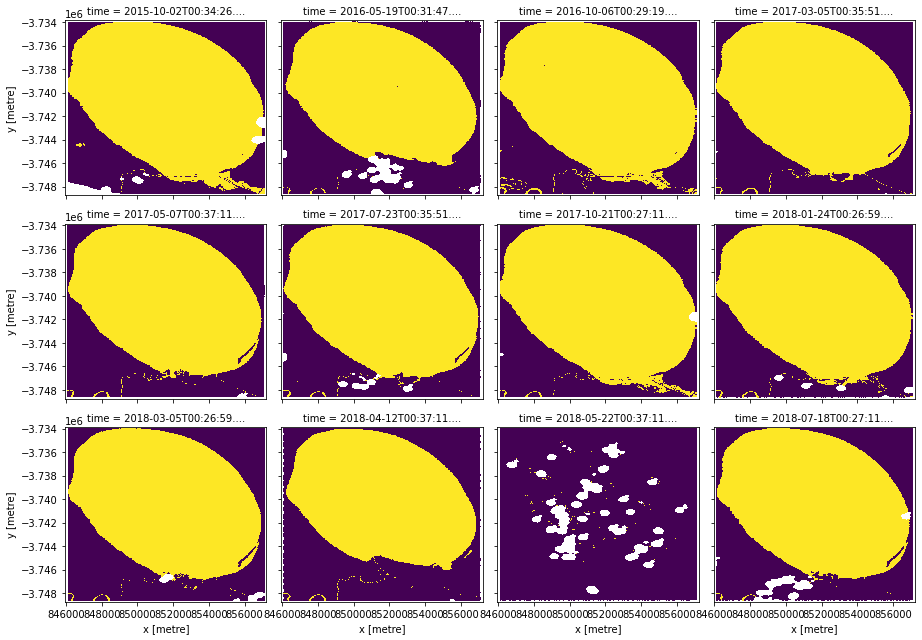

In [38]:
s2_wofs.isel(time=range(0, 120, 10)).astype(float).plot(
    col="time", col_wrap=4, add_colorbar=False
)

## Extract the time series

Next we apply the waterbody as a mask.

In [39]:
# Convert the shape into a raster mask:
mask = xr_rasterize(shape, s2_wofs)

In [40]:
# Apply the mask:
s2_wofs_masked = s2_wofs.where(mask)

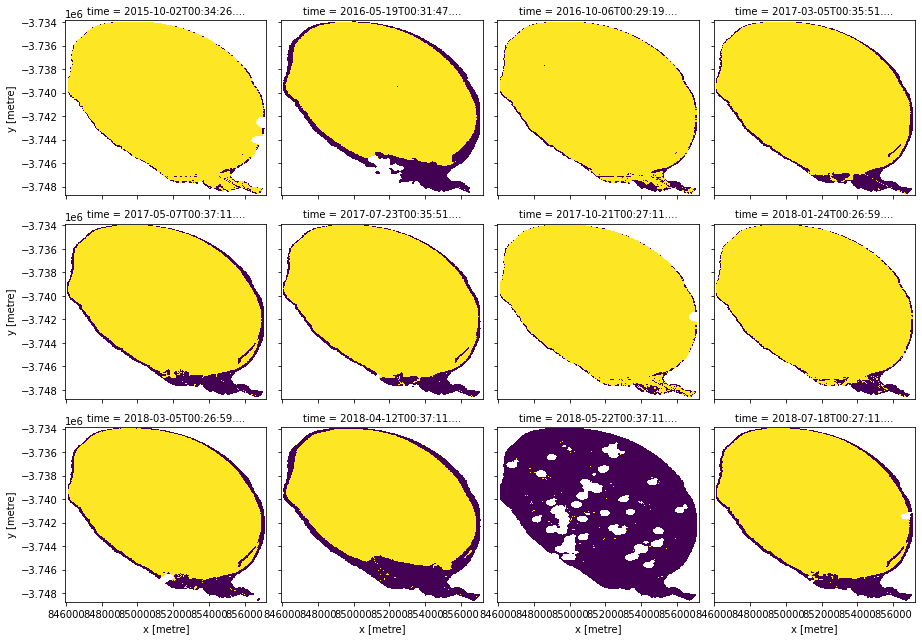

In [41]:
# Visualise the results
s2_wofs_masked.isel(time=range(0, 120, 10)).astype(float).plot(
    col="time", col_wrap=4, add_colorbar=False
)

The time series is then just the sum of valid pixels.

In [42]:
ts_sa_s2 = s2_wofs_masked.sum(dim=["x", "y"])

Apply a filter that excludes scenes with less than 90% valid pixels. Count how many pixels are missing compared to how many pixels are in the mask:

In [43]:
masked_pixel_counts = s2_wofs_masked.isnull().sum(dim=["x", "y"])
n_masked_pixels = (1 - mask).sum()
missing_pixel_counts = masked_pixel_counts - n_masked_pixels

In [44]:
# Convert to a percentage of the maximum extent
missing_pixel_pcs = missing_pixel_counts / mask.sum()

In [45]:
# Apply the filter
ts_sa_s2 = ts_sa_s2.sel(time=missing_pixel_pcs <= 0.1)

We can also estimate the upper bound as the measured value plus the number of missing pixels.

In [46]:
upper_bound = ts_sa_s2 + missing_pixel_counts

One frame seems to be missing all pixels, so we will exclude it.

In [47]:
upper_bound = upper_bound.sel(time=ts_sa_s2 > 0)
ts_sa_s2 = ts_sa_s2.sel(time=ts_sa_s2 > 0)

Text(0, 0.5, 'Surface area (px$^2$)')

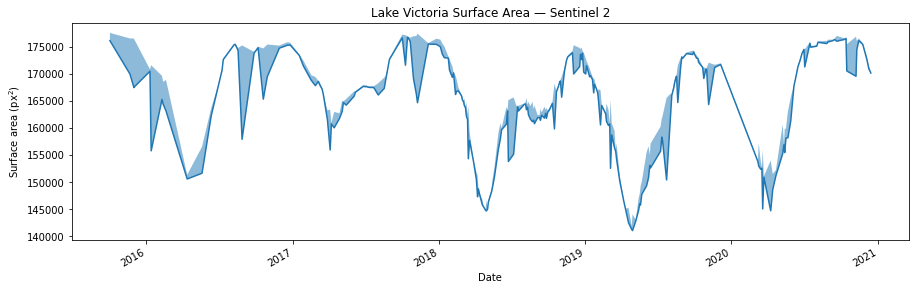

In [48]:
plt.figure(figsize=(15, 4))
plt.fill_between(ts_sa_s2.time.values, ts_sa_s2, upper_bound, alpha=0.5)
ts_sa_s2.plot()
plt.title("Lake Victoria Surface Area — Sentinel 2")
plt.xlabel("Date")
plt.ylabel("Surface area (px$^2$)")

## Combine the time series

Combine both surface area time series to get a high(er) cadence time series.

In [49]:
df = ts_sa_s2.to_dataframe(name="px_wet")
df.index = df.index.tz_localize("UTC")
ts_sa_s2 = df

In [50]:
ts_sa_s2["px_wet_upper"] = upper_bound

In [51]:
ts_sa_concat = pd.concat([ts_sa, ts_sa_s2])

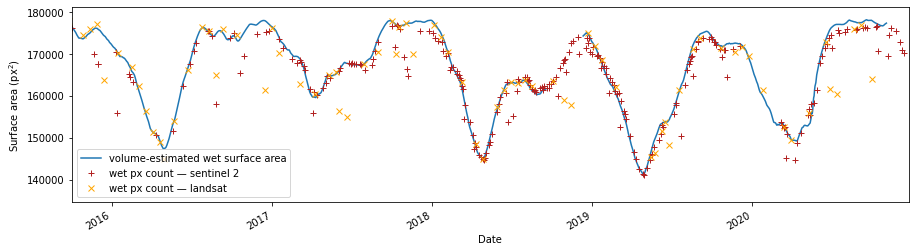

In [52]:
plt.figure(figsize=(15, 4))
plt.plot(ts_vol.index, ts_vol.px_wet_est, label="volume-estimated wet surface area")
ts_sa_s2.px_wet.plot(
    label="wet px count — sentinel 2", marker="+", linewidth=0, c="firebrick"
)
ts_sa.px_wet.plot(label="wet px count — landsat", marker="x", linewidth=0, c="orange")
plt.xlim(ts_sa_s2.index[0], ts_vol.index[-1])
plt.ylabel("Surface area (px$^2$)")
plt.xlabel("Date")
plt.legend();

## Comparison of all time series

Let's compare the Sentinel 2 surface areas, the Landsat surface areas, and the volume gauge surface areas.

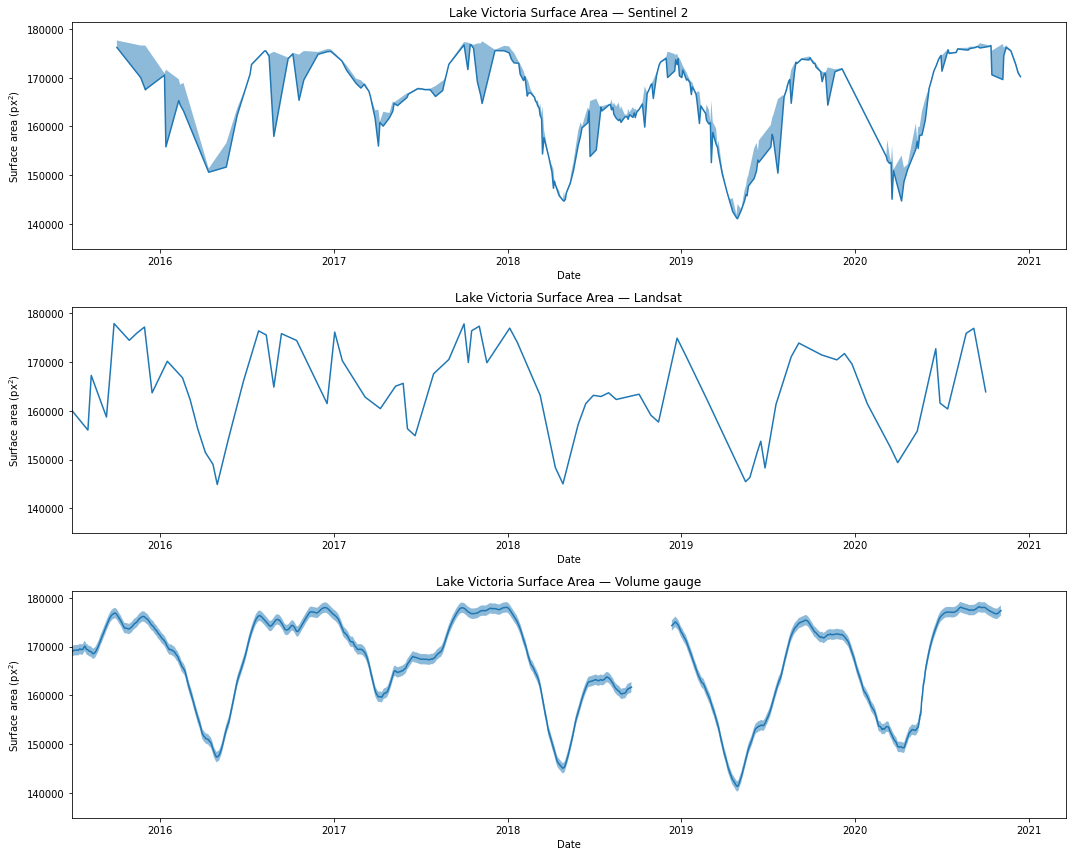

In [53]:
fig, axs = plt.subplots(3, 1, figsize=(15, 12))

axs[0].plot(ts_sa_s2.index, ts_sa_s2["px_wet"])
axs[0].fill_between(
    ts_sa_s2.index, ts_sa_s2["px_wet"], ts_sa_s2["px_wet_upper"], alpha=0.5
)
axs[0].set_title("Lake Victoria Surface Area — Sentinel 2")
axs[1].plot(ts_sa.index, ts_sa["px_wet"])
axs[1].set_title("Lake Victoria Surface Area — Landsat")
axs[2].plot(ts_vol.index, ts_vol["px_wet_est"])
axs[2].fill_between(
    ts_vol.index,
    ts_vol["px_wet_est"] - est_err,
    ts_vol["px_wet_est"] + est_err,
    alpha=0.5,
)
axs[2].set_title("Lake Victoria Surface Area — Volume gauge")
for ax in axs:
    ax.set_xlabel("Date")
    ax.set_ylabel("Surface area (px$^2$)")
    ax.set_xlim(axs[0].get_xlim())
    ax.set_ylim(axs[2].get_ylim())
plt.tight_layout()

Or all in one plot:

(735873.0239123495, 737773.0188775926)

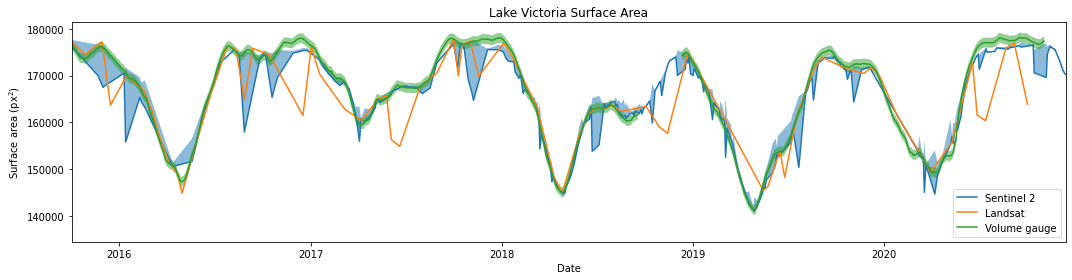

In [54]:
fig, ax = plt.subplots(figsize=(15, 4))

ax.plot(ts_sa_s2.index, ts_sa_s2["px_wet"], c="C0", label="Sentinel 2")
ax.fill_between(
    ts_sa_s2.index, ts_sa_s2["px_wet"], ts_sa_s2["px_wet_upper"], alpha=0.5, fc="C0"
)
ax.set_title("Lake Victoria Surface Area")
ax.plot(ts_sa.index, ts_sa["px_wet"], c="C1", label="Landsat")
ax.plot(ts_vol.index, ts_vol["px_wet_est"], c="C2", label="Volume gauge")
ax.fill_between(
    ts_vol.index,
    ts_vol["px_wet_est"] - est_err,
    ts_vol["px_wet_est"] + est_err,
    alpha=0.5,
    fc="C2",
)
ax.set_xlabel("Date")
ax.set_ylabel("Surface area (px$^2$)")
plt.legend()
plt.tight_layout()
plt.xlim(ts_sa_s2.index.min(), ts_sa_s2.index.max())

## Evaluation

What is the mean squared error for Landsat WOfS and S2 WOfS? Note that this is biased by the fact we estimated the volume based on Landsat observations.

In [55]:
ts_sa_normalised = ts_sa.copy()
ts_sa_normalised.index = ts_sa.index.normalize()

In [56]:
ts_sa_s2_normalised = ts_sa_s2.copy()
ts_sa_s2_normalised.index = ts_sa_s2.index.normalize()

Restrict both time series to the same time span.

In [57]:
min_time = max(ts_sa_s2_normalised.index.min(), ts_sa_normalised.index.min())
max_time = min(ts_sa_s2_normalised.index.max(), ts_sa_normalised.index.max())

In [58]:
ts_sa_s2_normalised = ts_sa_s2_normalised[
    (ts_sa_s2_normalised.index <= max_time) & (ts_sa_s2_normalised.index >= min_time)
]
ts_sa_normalised = ts_sa_normalised[
    (ts_sa_normalised.index <= max_time) & (ts_sa_normalised.index >= min_time)
]

In [59]:
ts_vol_ = ts_vol[(ts_vol.index <= max_time) & (ts_vol.index >= min_time)]

In [60]:
mse_landsat = np.nanmean((ts_sa_normalised.px_wet - ts_vol_.px_wet_est) ** 2)
mse_s2 = np.nanmean((ts_sa_s2_normalised.px_wet - ts_vol_.px_wet_est) ** 2)

In [61]:
print(f"MSE (Landsat): {mse_landsat:.2e}")
print(f"MSE (Sentinel 2): {mse_s2:.2e}")

MSE (Landsat): 2.35e+07
MSE (Sentinel 2): 9.37e+06


The Sentinel 2 estimated surface areas have a lower mean squared error than the Landsat estimated surface areas. This suggests that even without correction factors, new data points introduced by including Sentinel 2 observations in DEA Waterbodies can be expected to be at least as accurate as existing Landsat-derived data points.

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** January 2021

**Compatible datacube version:**

In [62]:
datacube.__version__

'1.8.3'

## Tags